In [3]:
import math
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch
from scipy.stats import norm

In [224]:
def get_sigm(t):
    if t<=1/12:
        return 0.12
    elif t<=1/4:
        return 0.13
    elif t<=5/12:
        return 0.15
    else:
        return 0.17

    
def get_sigms2(T, N):
    dt = T/N
    sigms = []
    for i in range(N):
        t = i*dt
        sigm = get_sigm(t)
        sigms.append(sigm)
    sigms = np.array(sigms)
    sigms2 = sigms**2
    return sigms2


def get_vol(i, sigms2, T, N):
    dt = T/N
    sub_sigms2 = sigms2[i:]*dt
    vol = 1/(T-i*dt)*np.sum(sub_sigms2)
    vol = vol**0.5
    return vol


def St_simulation_SDE(S0, T, N, r):
    dt = T/N
    dBs = np.random.normal(0, dt**0.5, N)
    path = []
    St = S0
    path.append(St)
    for i,dB_i in enumerate(dBs):
        sigm_i = get_sigm(i*T/N)
        St = St + sigm_i*St*dB_i+r*St*dt
        path.append(St)
    return path


def continous_value(path, Deltas, Ct_path, r, T, N):
    dt = T/N
    Vs = []
    v_i = Ct_path[0]
    Vs = [v_i]
    R = math.exp(r*dt)
    for i, delta in enumerate(Deltas):
        St_plus = path[i+1]
        St = path[i]
        Ct = Ct_path[i]
        v_i = v_i*R+delta*(St_plus-St*R)
        Vs.append(v_i)
    return Vs

        
def Ct_value(path, K, T, N):
    dt = T/N
    sigms2 = get_sigms2(T, N)
    Ct_path = []
    Deltas = []
    Deltas_dis = []
    for i in range(N):
        St = path[i]
        Ti = T - i*dt
        vol_i = get_vol(i, sigms2, T, N)
        d1 = (math.log(St/K)+(r+0.5*vol_i**2)*Ti)/(vol_i*(Ti)**0.5)
        d2 = (math.log(St/K)+(r-0.5*vol_i**2)*Ti)/(vol_i*(Ti)**0.5)
        N1 = norm.cdf(d1)
        N2 = norm.cdf(d2)
        Ct = St*N1 - K*math.exp(-r*Ti)*N2
        Ct_path.append(Ct)
        Deltas.append(N1)
        if i % 5 == 0:
            for i in range(5):
                Deltas_dis.append(N1)
    return Ct_path, Deltas, Deltas_dis


def plot_path(paths, names, T, xname, yname):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    num = len(names)
    plt.figure(figsize=(6, 4))
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['figure.dpi'] = 200
    for i in range(num):
        path_i = paths[i]
        num_ps = len(path_i)  
        index = [i*T/(num_ps-1) for i in range(num_ps)]
        plt.plot(index, path_i, color=colors[i], 
                 linestyle="-", linewidth=0.9, label=names[i])
        
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title('{}@{}'.format(yname,xname))
    plt.legend()
    sns.set()
    plt.show()

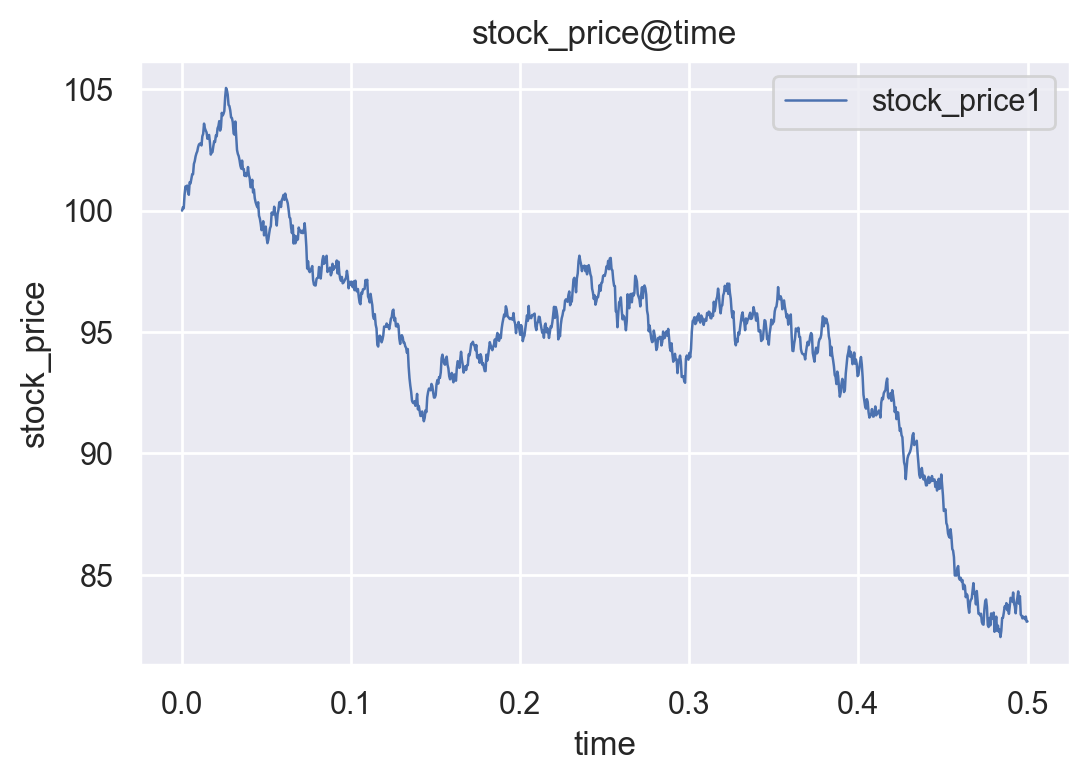

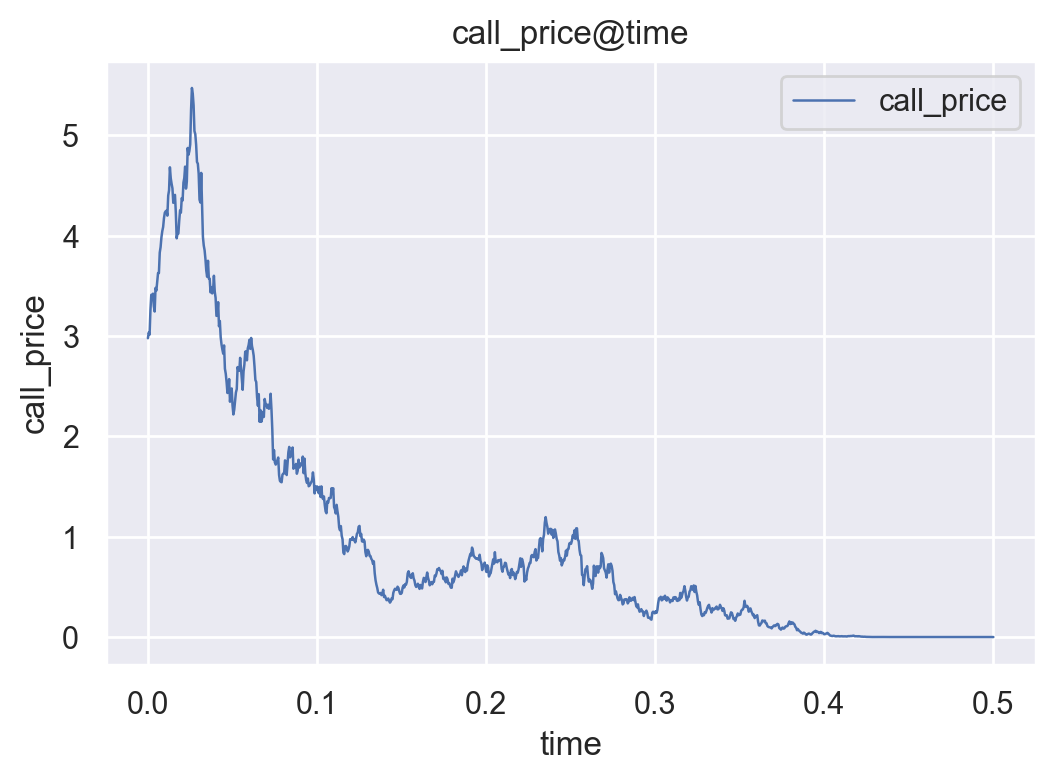

In [225]:
S0=100
T = 1/2
N = 1000
r=0.05
K = 105

# sumulate stock price with 
path = St_simulation_SDE(S0, T, N, r)
paths = []
paths.append(path)
names = ['stock_price1']
xname = 'time'
yname = 'stock_price'
plot_path(paths, names, T, xname, yname)

# call price
Ct_path, Deltas, Deltas_dis = Ct_value(path, K, T, N)
paths = []
paths.append(Ct_path)
names = ['call_price']
xname = 'time'
yname = 'call_price'
plot_path(paths, names, T, xname, yname)

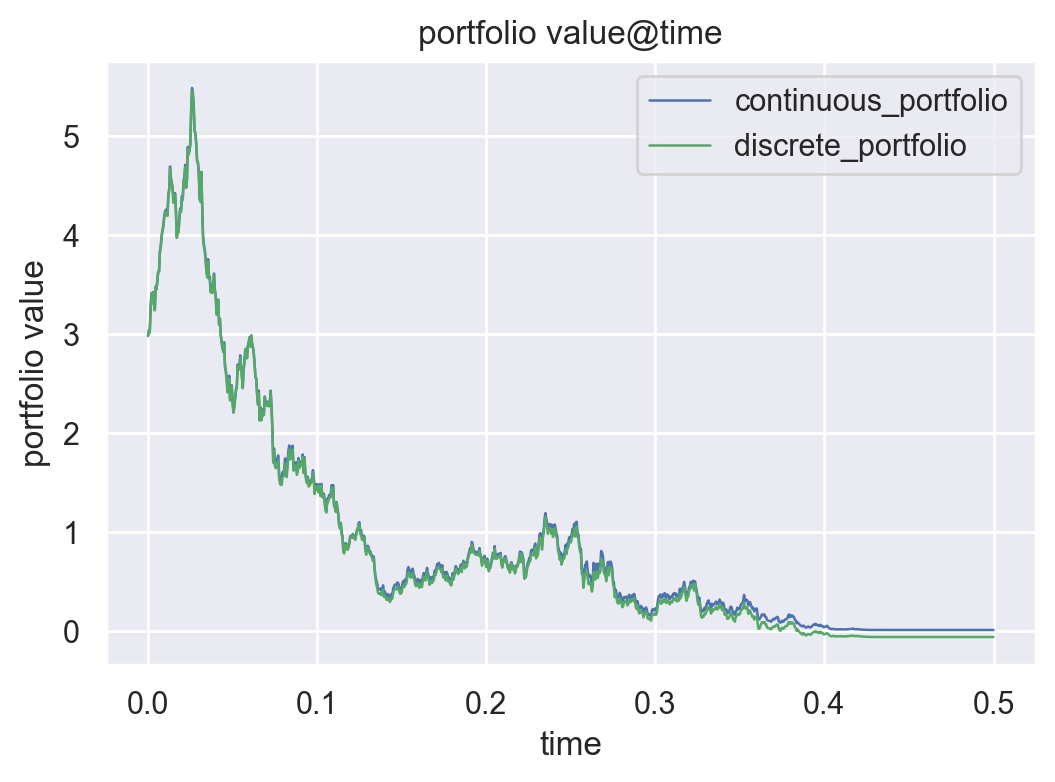

In [226]:
# continuous hedging portfolio
vals = continous_value(path, Deltas, Ct_path, r, T, N)
discrete_vals = continous_value(path, Deltas_dis, Ct_path, r, T, N)
paths = []
paths.append(vals)
paths.append(discrete_vals)
names = ['continuous_portfolio', 'discrete_portfolio']
xname = 'time'
yname = 'portfolio value'
plot_path(paths, names, T, xname, yname)

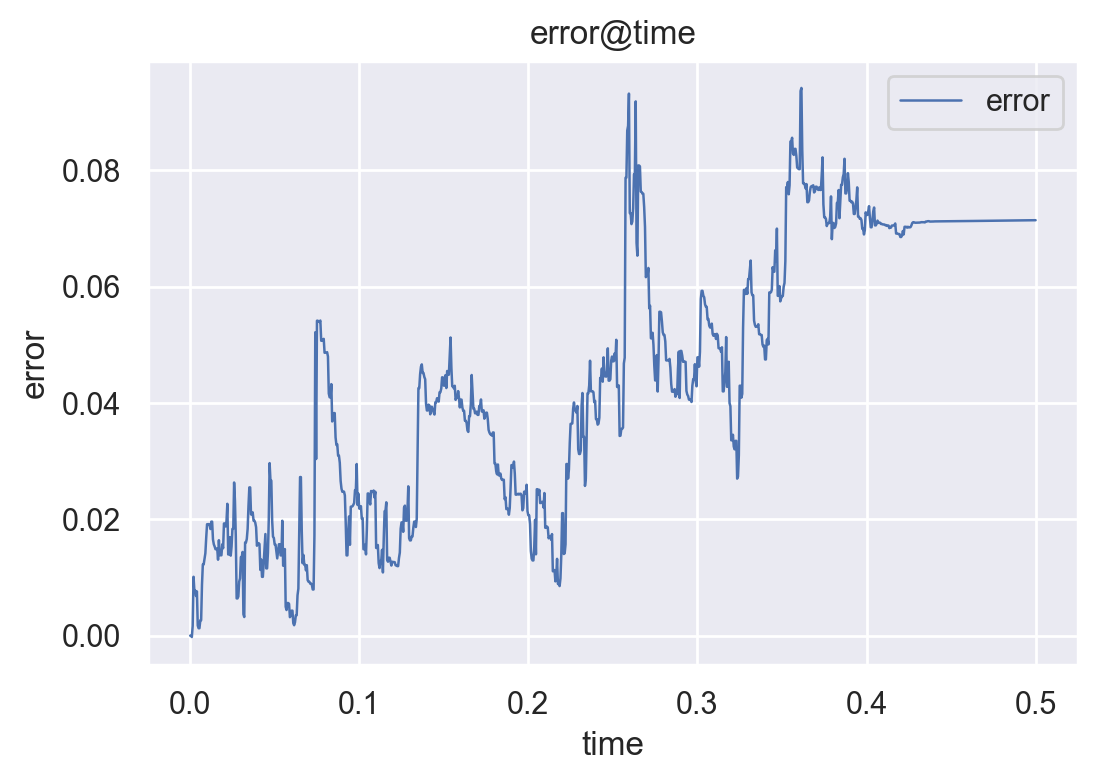

In [227]:
error = (np.array(vals)-np.array(discrete_vals)).tolist()
paths = []
paths.append(error)
names = ['error']
xname = 'time'
yname = 'error'
plot_path(paths, names, T, xname, yname)

In [ ]:
S0=100
T = 1/2
N = 1000
r=0.05
K = 105
error = []
for i in range(1000):
    # sumulate stock price with 
    path = St_simulation_SDE(S0, T, N, r)
    # call price
    Ct_path, Deltas, Deltas_dis = Ct_value(path, K, T, N)
    # continuous hedging portfolio
    vals = continous_value(path, Deltas, Ct_path, r, T, N)
    discrete_vals = continous_value(path, Deltas_dis, Ct_path, r, T, N)
    error_i = (np.array(vals)-np.array(discrete_vals)).tolist()
    error += error_i

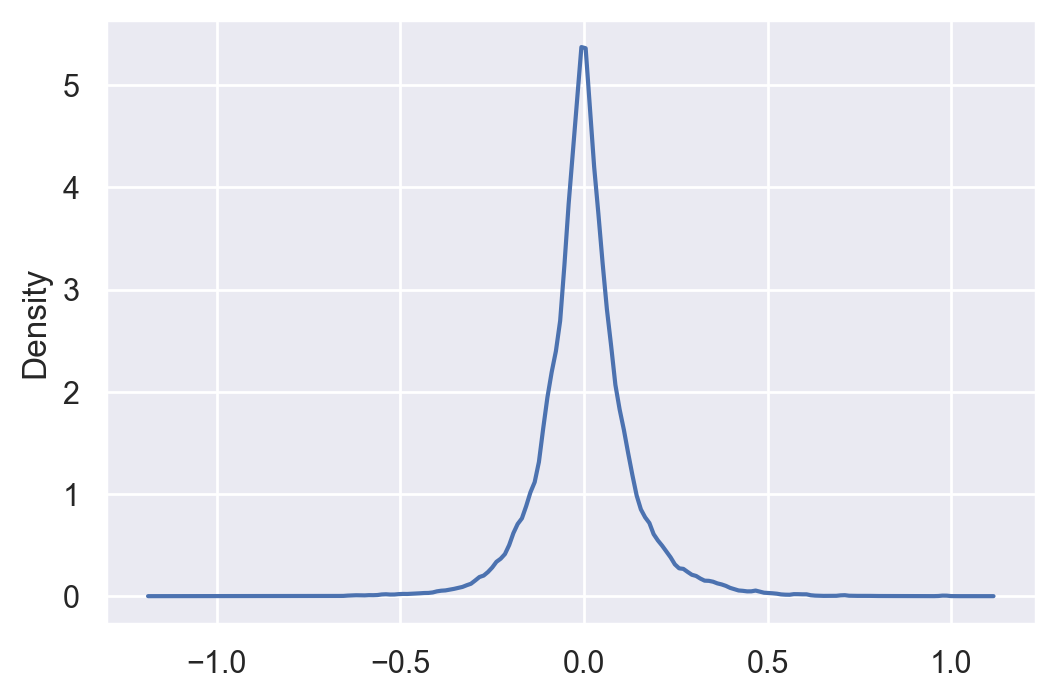

In [232]:
sns.kdeplot(error)

Consider the data on the excel file. For each value of the call and for each of the 3 stock prices compute the implied volatility. Plot the implied volatility as a function of the strike and time to maturity (volatility surface). Explain if you observe any smile or skew.

In [403]:
def Ct_Ct_dev(St, K, sigma, expir_t, r):
    d1 = (math.log(St/K) + (r+0.5*sigma**2)*expir_t)/(sigma*expir_t**0.5)
    N1 = norm.cdf(d1)
    d2 = (math.log(St/K) + (r-0.5*sigma**2)*expir_t)/(sigma*expir_t**0.5)
    N2 = norm.cdf(d2)
    Ct = St*N1 - K*math.exp(-r*expir_t)*N2
    Ct_dev = St*N1*expir_t**0.5
    return Ct, Ct_dev


def get_sigma0(St, et, r, K):
    m = St/(K*math.exp(-r*et))
    sigm0 = (2*abs(math.log(m))/et)**0.5
    return sigm0
    

def newton(St, expir_t, K, Ct_m, r):
    error_end = 0.000001
    erorr = 0.1
    sigm0 = get_sigma0(St, expir_t, r, K)
    while erorr>error_end:
        Ct, Ct_dev = Ct_Ct_dev(St, K, sigm0, expir_t, r)
        sigm_temp = sigm0
        sigm0 = sigm_temp - (Ct-Ct_m)/Ct_dev
        erorr = abs(sigm0 - sigm_temp)
    return sigm0

def plot_surface(X, Y, alphas, comp_name):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.ticker import LinearLocator, FormatStrFormatter
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(X, Y)
    Z = alphas
    surf = ax.plot_surface(X, Y, Z,  cmap='rainbow')
    ax.set_xlabel('strike price', fontsize=10)
    ax.set_ylabel('days to expiration', fontsize='medium') 
    ax.set_zlabel('impiled volatility', fontsize='medium') 
    ax.set_title('{} implied volatility surface'.format(comp_name), fontsize='medium') 
    fig.colorbar(surf, shrink=np.min(Z), aspect=np.max(Z))
    plt.show()

In [365]:
rs = [0.0492,0.0485,0.0491]
ets = [25,60,151]
ets = (np.array(ets)/260).tolist()
import pandas as pd
s_c = pd.read_csv('./new_ton.csv')
St_call = s_c.to_numpy()
s_c

,price,strike,call1,call2,call3
0,42.27,40.0,3.30,4.30,5.30
1,42.27,42.5,2.70,3.90,4.80
2,42.27,45.0,1.25,2.40,3.30
3,108.90,100.0,12.00,14.10,18.70
4,108.90,110.0,4.40,8.10,11.40
5,108.90,120.0,1.10,3.60,7.50
6,55.19,50.0,6.50,8.13,10.00
7,55.19,55.0,3.00,4.50,6.88
8,55.19,60.0,0.94,2.38,4.50
9,NaN,NaN,NaN,NaN,NaN


In [400]:
sigmas = np.zeros((9, 3))
for i in range(9):
    for j in range(3):
        r = rs[j]
        et = ets[j]
        K = St_call[i, 1]
        Ct_m = St_call[i, j+2]
        St = St_call[i, 0]
        sigm0 = get_sigma0(St, et, r, K)
        sigmas[i, j] = newton(St, et, K, Ct_m, r)
sigmas

array([[0.35705723, 0.3487585 , 0.27069454],
       [0.51953119, 0.4686098 , 0.33945051],
       [0.42611077, 0.4095425 , 0.30588836],
       [0.4835234 , 0.40937896, 0.38295159],
       [0.34698711, 0.38589963, 0.31698389],
       [0.32288036, 0.34416462, 0.31977451],
       [0.47057461, 0.47119708, 0.39163334],
       [0.40756492, 0.38975431, 0.36277217],
       [0.36625095, 0.37651699, 0.34483514]])

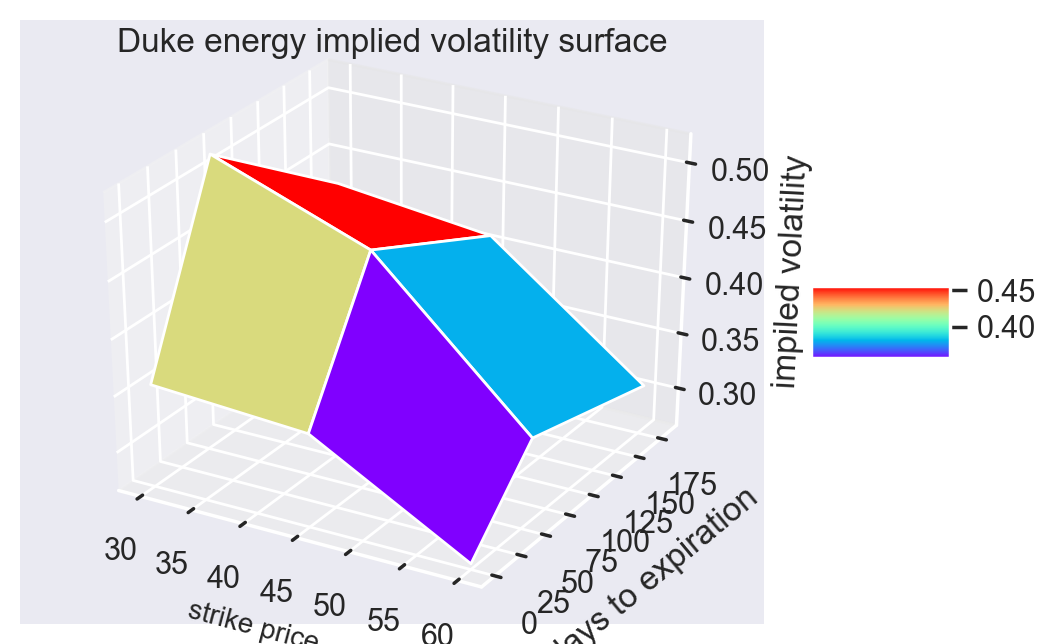

In [406]:
Ks = [30, 45, 60]
days = [0, 60, 180]
plot_surface(Ks, days, sigmas[0:3, :], 'Duke energy')

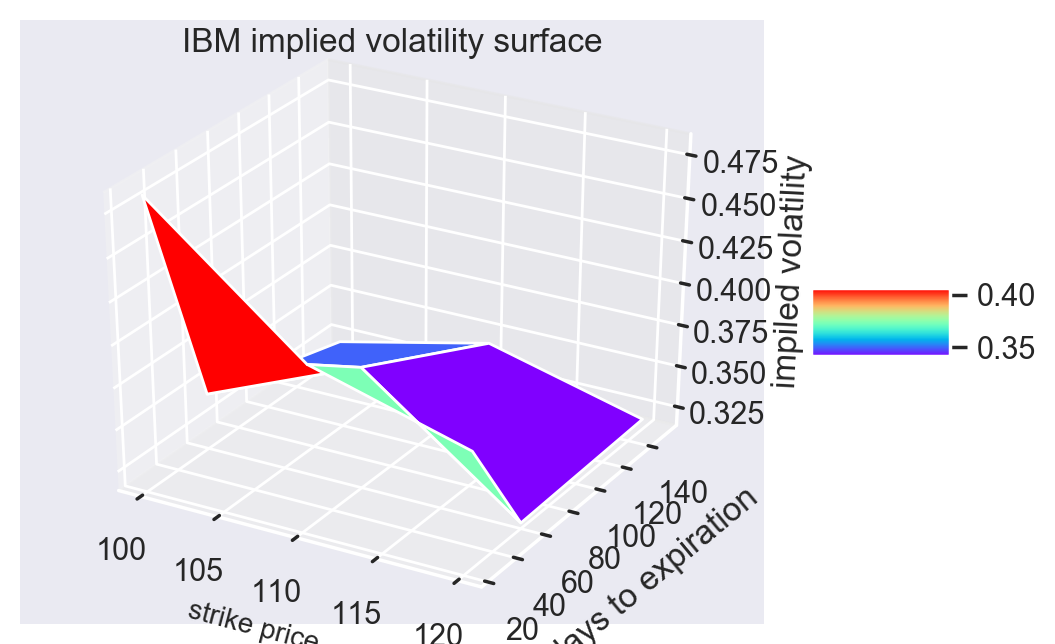

In [408]:
Ks = [100, 110, 120]
days = [25, 60, 151]
plot_surface(Ks, days, sigmas[3:6, :], 'IBM')

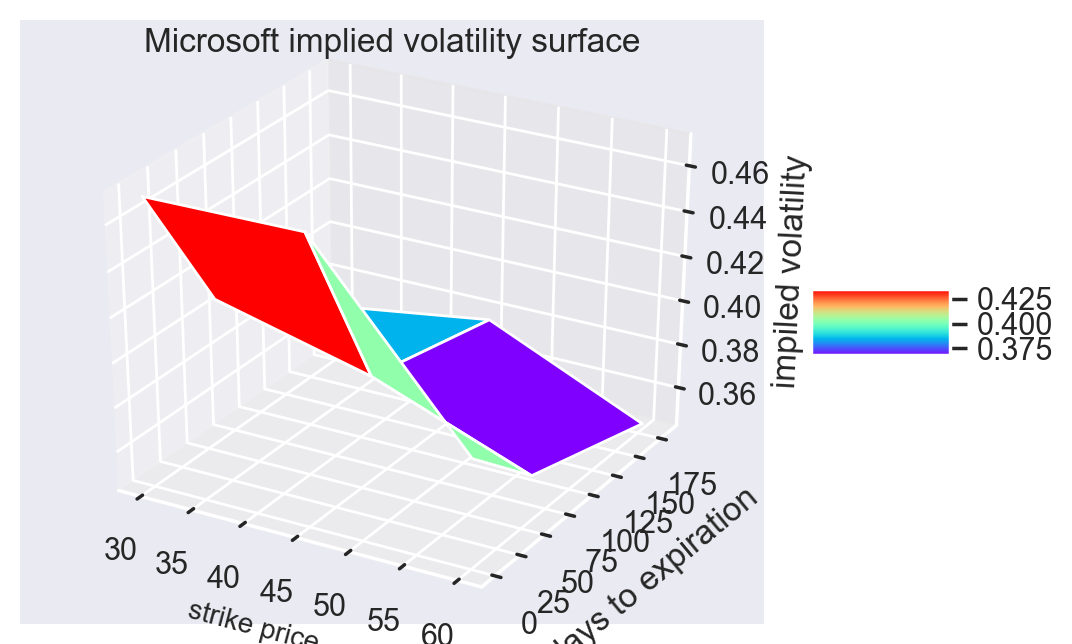

In [409]:
Ks = [30, 45, 60]
days = [0, 60, 180]
plot_surface(Ks, days, sigmas[6:9, :], 'Microsoft')